In [1]:
from datetime import datetime
import regex as re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()
countries = {"Germany": "D",
             "Austria": "A",
             "Belgium" : "B",
             "Spain": "E",
             "France": "F",
             "Italy": "I",
             "Luxembourg": "L",
             "Netherlands": "NL"}

### Load Dataset

In [3]:
sorted(os.listdir("Data"))

['2022-11-07_17_50_21_282909.csv',
 '2022-11-07_17_59_56_035522.csv',
 '2022-11-08_12_03_00_239472.csv',
 'visited_urls.json']

In [4]:
file_name = sorted(os.listdir("data")) [0]
file_path = os.path.join("data", file_name)

#df = pd.read_csv(file_path, sep=';', index_col='url')
df = pd.concat([pd.read_csv(os.path.join("data", file),sep=";", index_col='url') for file in os.listdir("data") if file.endswith(".csv")],axis=0,sort=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 807 entries, /annunci/renault-clio-0-9-tci-90-hp-intense-benzina-grigio-6588b7a7-3f64-4471-94fd-8af6ee13ba20 to /annunci/ford-fiesta-5p-1-5-tdci-titanium-85cv-diesel-nero-2d26d021-f86b-416d-8bc2-be64a94f4d4f
Data columns (total 90 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Acconto                           807 non-null    object 
 1   Altre fonti energetiche           50 non-null     object 
 2   Anno                              772 non-null    object 
 3   Anno di produzione                68 non-null     float64
 4   Anticipo                          575 non-null    object 
 5   Cambio cinghia distribuzione      21 non-null     object 
 6   Carburante                        763 non-null    object 
 7   Carrozzeria                       807 non-null    object 
 8   Chilometraggio                    774 non-null    object 
 9   Chilometraggio p

### Rename Index

In [6]:
df['url'] = df.index.str.strip('/annunci/')
df = df.reset_index(drop=True)

### Remove Useless columns

In [7]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh", figsize=(12,10))
        plt.show()
    else:
        print('No NAs found')



c:\Users\bestengage\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\bestengage\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


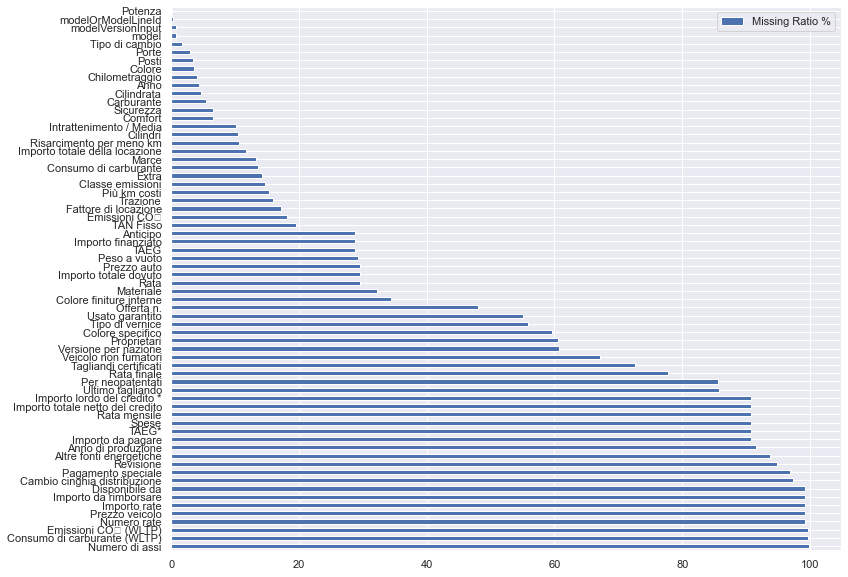

In [8]:
plot_nas(df)

In [9]:
#remove cols with more than 20% values missing, with some exception 
na_df = (df.isnull().sum() / len(df)) * 100      
col_with_na = na_df[na_df>20].index

exclude_from_removal = ['Prezzo auto', 'Usato garantito', 'Proprietari', 'Tagliandi certificati', 'Emissioni CO₂', 'Peso a vuoto']
col_to_remove = [el for el in col_with_na if el not in exclude_from_removal]

print(col_to_remove, len(col_to_remove))

['Altre fonti energetiche', 'Anno di produzione', 'Anticipo', 'Cambio cinghia distribuzione', 'Colore finiture interne', 'Colore specifico', 'Consumo di carburante (WLTP)', 'Disponibile da', 'Emissioni CO₂ (WLTP)', 'Importo da pagare', 'Importo da rimborsare', 'Importo finanziato', 'Importo lordo del credito *', 'Importo rate', 'Importo totale dovuto', 'Importo totale netto del credito', 'Materiale', 'Numero di assi', 'Numero rate', 'Offerta n.', 'Pagamento speciale', 'Per neopatentati', 'Prezzo veicolo', 'Rata', 'Rata finale', 'Rata mensile', 'Revisione', 'Spese', 'TAEG', 'TAEG*', 'Tipo di vernice', 'Ultimo tagliando', 'Veicolo non fumatori', 'Versione per nazione'] 34


In [10]:
df = df.drop(labels=col_to_remove, axis=1)

### Rename columns

In [11]:
# remove whitespaces and newlines and other characters
df.columns = df.columns.str.replace('\n',' ')
df.columns = df.columns.str.replace(' ','_')
for char in [';', '.', ',', ':']:
    df.columns = df.columns.str.replace(char,'')

col_rename_dict = {
    'Cilindrata':'Cilindrata_cm3',
    'Consumo_di_carburante':'Consumo_di_carburante_kmL',
    'Emissioni_CO₂':'Emissioni_CO2_gKm',
    'Peso_a_vuoto':'Peso_a_vuoto_kg'
}

df = df.rename(columns=col_rename_dict)

print(df.columns)


Index(['Acconto', 'Anno', 'Carburante', 'Carrozzeria', 'Chilometraggio',
       'Chilometraggio_pa', 'Cilindrata', 'Cilindri', 'Classe_emissioni',
       'Colore', 'Comfort', 'Consumo_di_carburante',
       'Costo_del_trasferimento_', 'Costo_di_registrazione', 'Durata',
       'Emissioni_CO₂', 'Extra', 'Fattore_di_locazione',
       'Importo_totale_della_locazione', 'Interessi_passivi_pagati_pa',
       'Intrattenimento_/_Media', 'Marce', 'Peso_a_vuoto', 'Più_km_costi',
       'Porte', 'Posti', 'Potenza', 'Prestito_netto', 'Prezzo_auto',
       'Proprietari', 'Quota_mensile', 'Risarcimento_per_meno_km', 'Sicurezza',
       'TAN_Fisso', 'Tagliandi_certificati', 'Tasso_di_interesse_effettivo',
       'Tipo_di_cambio', 'Tipo_di_contratto', 'Tipo_di_veicolo',
       'Totale_unico', 'Trazione', 'Usato_garantito', 'city', 'country',
       'countryCode', 'date', 'dealer', 'makeId', 'maker', 'model',
       'modelOrModelLineId', 'modelVersionInput', 'price', 'privateSeller',
       'street', 

C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_28568/3471849563.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(char,'')


In [18]:
df.Potenza.value_counts(dropna=False)

110 kW (150 CV)    74
88 kW (120 CV)     64
85 kW (116 CV)     53
70 kW (95 CV)      45
81 kW (110 CV)     38
                   ..
283 kW (385 CV)     1
221 kW (300 CV)     1
357 kW (485 CV)     1
121 kW (165 CV)     1
83 kW (113 CV)      1
Name: Potenza, Length: 110, dtype: int64

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head())

,Acconto,Anno,Carburante,Carrozzeria,Chilometraggio,Chilometraggio_pa,Cilindrata_cm3,Cilindri,Classe_emissioni,Colore,Comfort,Consumo_di_carburante_kmL,Costo_del_trasferimento_,Costo_di_registrazione,Durata,Emissioni_CO2_gKm,Extra,Fattore_di_locazione,Importo_totale_della_locazione,Interessi_passivi_pagati_pa,Intrattenimento_/_Media,Marce,Peso_a_vuoto_kg,Più_km_costi,Porte,Posti,Potenza,Prestito_netto,Prezzo_auto,Proprietari,Quota_mensile,Risarcimento_per_meno_km,Sicurezza,TAN_Fisso,Tagliandi_certificati,Tasso_di_interesse_effettivo,Tipo_di_cambio,Tipo_di_contratto,Tipo_di_veicolo,Totale_unico,Trazione,Usato_garantito,city,country,countryCode,date,dealer,makeId,maker,model,modelOrModelLineId,modelVersionInput,price,privateSeller,street,zip,url
0,"€ 0,-",04/2017,Benzina,Berlina,120.398 km,10.000 km,NaN,3.0,Euro 6,Grigio,Chiusura centralizzata senza chiave;Climatizza...,0 l/100 km (comb.)0 l/100 km (urbano)0 l/100 k...,"€ 999,-","€ 0,-",48 Monate,NaN,Cerchi in lega,"0,82","€ 20.208,-","4,97 % gebunden",Autoradio;Bluetooth;MP3;Vivavoce,5.0,NaN,"€ 0,0952",4.0,5.0,66 kW (90 CV),"€ 36.880,-","€ 11.800,-",1.0,"€ 421,-","€ 0,0393",ABS;Airbag conducente;Airbag laterali;Airbag p...,"6,45 %",NaN,"4,97 %",Manuale,Kilometerleasing,Usato,"€ 999,-",Anteriore,12 mesi,Udine - Ud,Italy,IT,2022-11-07 17:50:40.113020,False,60,Renault,Clio,1961.0,0.9 TCI 90 HP INTENSE,"€ 11.800,-5",False,Via Caratti Umberto,33100,renault-clio-0-9-tci-90-hp-intense-benzina-gri...
1,"€ 5.196,-",05/2018,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,99.800 km,0 km,1.560 cm³,4.0,NaN,Grigio,Alzacristalli elettrici;Bracciolo;Chiusura cen...,"4,4 l/100 km (comb.)4,9 l/100 km (urbano)4,1 l...",Keine Angabe,Keine Angabe,42 Monate,114 g/km (comb.),Cerchi in lega;Controllo vocale;Freno di stazi...,NaN,"€ 14.688,-","3,79 % gebunden",Android Auto;Apple CarPlay;Autoradio;Autoradio...,6.0,1.390 kg,NaN,5.0,5.0,88 kW (120 CV),"€ 25.980,-","€ 24.900,-",1.0,"€ 226,-","€ 0,0000",ABS;Adaptive Cruise Control;Airbag conducente;...,"7,30 %",Sì,"3,79 %",Automatico,Kilometerleasing,Usato,"€ 5.196,-",Anteriore,NaN,Afragola - Na,Italy,IT,2022-11-07 17:50:40.890436,False,55,Peugeot,3008,19217.0,3008 1.6 bluehdi GT Line eat CAMBIO AUTOMATICO,"€ 24.900,-5",False,Via A. Mancini,80021,peugeot-3008-3008-1-6-bluehdi-gt-line-eat-camb...
2,"€ 0,-",03/2020,Benzina 91,Station wagon,10.561 km,10.000 km,1.984 cm³,4.0,Euro 6d-TEMP,Argento,Alzacristalli elettrici;Bracciolo;Climatizzato...,"6,1 l/100 km (comb.)7,4 l/100 km (urbano)5,3 l...",Keine Angabe,Keine Angabe,42 Monate,133 g/km (comb.),"Cerchi in lega (17"");Controllo vocale;Gancio t...",NaN,NaN,"5,54 % kombiniert",Android Auto;Apple CarPlay;Bluetooth;Carica pe...,7.0,1.585 kg,"€ 0,0836",5.0,5.0,140 kW (190 CV),"€ 45.790,-",NaN,NaN,"€ 669,-","€ 0,0557",ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Sì,"5,68 %",Automatico,Kilometerleasing,Usato,"€ 0,-",Anteriore,24 mesi,Solbiate Olona - Varese - VA,Italy,IT,2022-11-07 17:50:41.749963,False,9,Audi,A4,1626.0,Avant 40 TFSI 190 CV S tronic Advanced,"€ 36.900,-1, 5",False,Via Dei Combattenti,21058,di-a4-avant-40-tfsi-190-cv-s-tronic-advanced-b...
3,"€ 0,-",05/2021,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,17.000 km,10.000 km,NaN,NaN,Euro 6d-TEMP,Bianco,NaN,NaN,"€ 828,-","€ 0,-",48 Monate,NaN,NaN,"1,16","€ 10.848,-","5,59 % gebunden",NaN,NaN,NaN,"€ 0,0780",NaN,NaN,110 kW (150 CV),"€ 18.768,-",NaN,1.0,"€ 226,-","€ 0,0490",NaN,NaN,NaN,"5,74 %",Manuale,Kilometerleasing,Usato,"€ 828,-",4x4,12 mesi,Salerno - Sa,Italy,IT,2022-11-07 17:50:43.447828,False,13,BMW,X1,19242.0,18D 150CV 6M. E6D-TEMP SS X-DRIVE SPORTLINE (N...,"€ 34.700,-1, 5",False,Via Roberto Wenner,84100,bmw-x1-18d-150cv-6m-e6d-temp-ss-x-drive-sportl...
4,"€ 5.575,22",11/2016,Diesel,SUV/Fuoristrada/Pick-up,87.000 km,10.000 km,1.685 cm³,4.0,Euro 6,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,"4,9 l/100 km (comb.)5,4 l/100 km (urbano)4,7 l...",Keine Angabe,Keine Angabe,36 Monate,129 g/km (comb.),"Cerchi in lega

In [68]:
price_pat = r'\€\s*(\d*),*'
km_pat = r'(\d*)\s*km'
pot_kw_pat = r'(\d*)\s*kW'
pot_cv_pat = r'\((\d*)\s*CV\)'
cil_cm3_pat = r'(\d*)\s*cm'

In [71]:
km_columns = ['Chilometraggio', 'Chilometraggio_pa']
price_columns = ['Prezzo_auto', 'price', 'Acconto']

In [73]:

for col in km_columns:
    df[col] = df[col].str.replace('.', '').str.extract(pat=km_pat).astype(np.float64)

for col in price_columns:
    df[col] = df[col].str.replace('.', '').str.extract(pat=price_pat).astype(np.float64)

df['Cilindrata_cm3'] = df['Cilindrata_cm3'].str.replace('.', '').str.extract(pat=cil_cm3_pat).astype(np.float64)
df['potenza_kw'] = df['Potenza'].str.replace('.', '').str.extract(pat=pot_kw_pat).astype(np.float64)
df['potenza_cv'] = df['Potenza'].str.replace('.', '').str.extract(pat=pot_cv_pat).astype(np.float64)
df = df.drop(columns=['Potenza'])


C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_28568/3585708275.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '').str.extract(pat=km_pat).astype(np.float64)
C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_28568/3585708275.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '').str.extract(pat=price_pat).astype(np.float64)
C:\Users\BESTEN~1\AppData\Local\Temp/ipykernel_28568/3585708275.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Cilindr

In [74]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.head())

,Acconto,Anno,Carburante,Carrozzeria,Chilometraggio,Chilometraggio_pa,Cilindrata_cm3,Cilindri,Classe_emissioni,Colore,Comfort,Consumo_di_carburante_kmL,Costo_del_trasferimento_,Costo_di_registrazione,Durata,Emissioni_CO2_gKm,Extra,Fattore_di_locazione,Importo_totale_della_locazione,Interessi_passivi_pagati_pa,Intrattenimento_/_Media,Marce,Peso_a_vuoto_kg,Più_km_costi,Porte,Posti,Prestito_netto,Prezzo_auto,Proprietari,Quota_mensile,Risarcimento_per_meno_km,Sicurezza,TAN_Fisso,Tagliandi_certificati,Tasso_di_interesse_effettivo,Tipo_di_cambio,Tipo_di_contratto,Tipo_di_veicolo,Totale_unico,Trazione,Usato_garantito,city,country,countryCode,date,dealer,makeId,maker,model,modelOrModelLineId,modelVersionInput,price,privateSeller,street,zip,url,potenza_kw,potenza_cv
0,0.0,04/2017,Benzina,Berlina,120398.0,10000.0,NaN,3.0,Euro 6,Grigio,Chiusura centralizzata senza chiave;Climatizza...,0 l/100 km (comb.)0 l/100 km (urbano)0 l/100 k...,"€ 999,-","€ 0,-",48 Monate,NaN,Cerchi in lega,"0,82","€ 20.208,-","4,97 % gebunden",Autoradio;Bluetooth;MP3;Vivavoce,5.0,NaN,"€ 0,0952",4.0,5.0,"€ 36.880,-",11800.0,1.0,"€ 421,-","€ 0,0393",ABS;Airbag conducente;Airbag laterali;Airbag p...,"6,45 %",NaN,"4,97 %",Manuale,Kilometerleasing,Usato,"€ 999,-",Anteriore,12 mesi,Udine - Ud,Italy,IT,2022-11-07 17:50:40.113020,False,60,Renault,Clio,1961.0,0.9 TCI 90 HP INTENSE,11800.0,False,Via Caratti Umberto,33100,renault-clio-0-9-tci-90-hp-intense-benzina-gri...,66.0,90.0
1,5196.0,05/2018,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,99800.0,0.0,1560.0,4.0,NaN,Grigio,Alzacristalli elettrici;Bracciolo;Chiusura cen...,"4,4 l/100 km (comb.)4,9 l/100 km (urbano)4,1 l...",Keine Angabe,Keine Angabe,42 Monate,114 g/km (comb.),Cerchi in lega;Controllo vocale;Freno di stazi...,NaN,"€ 14.688,-","3,79 % gebunden",Android Auto;Apple CarPlay;Autoradio;Autoradio...,6.0,1.390 kg,NaN,5.0,5.0,"€ 25.980,-",24900.0,1.0,"€ 226,-","€ 0,0000",ABS;Adaptive Cruise Control;Airbag conducente;...,"7,30 %",Sì,"3,79 %",Automatico,Kilometerleasing,Usato,"€ 5.196,-",Anteriore,NaN,Afragola - Na,Italy,IT,2022-11-07 17:50:40.890436,False,55,Peugeot,3008,19217.0,3008 1.6 bluehdi GT Line eat CAMBIO AUTOMATICO,24900.0,False,Via A. Mancini,80021,peugeot-3008-3008-1-6-bluehdi-gt-line-eat-camb...,88.0,120.0
2,0.0,03/2020,Benzina 91,Station wagon,10561.0,10000.0,1984.0,4.0,Euro 6d-TEMP,Argento,Alzacristalli elettrici;Bracciolo;Climatizzato...,"6,1 l/100 km (comb.)7,4 l/100 km (urbano)5,3 l...",Keine Angabe,Keine Angabe,42 Monate,133 g/km (comb.),"Cerchi in lega (17"");Controllo vocale;Gancio t...",NaN,NaN,"5,54 % kombiniert",Android Auto;Apple CarPlay;Bluetooth;Carica pe...,7.0,1.585 kg,"€ 0,0836",5.0,5.0,"€ 45.790,-",NaN,NaN,"€ 669,-","€ 0,0557",ABS;Airbag conducente;Airbag laterali;Airbag p...,NaN,Sì,"5,68 %",Automatico,Kilometerleasing,Usato,"€ 0,-",Anteriore,24 mesi,Solbiate Olona - Varese - VA,Italy,IT,2022-11-07 17:50:41.749963,False,9,Audi,A4,1626.0,Avant 40 TFSI 190 CV S tronic Advanced,36900.0,False,Via Dei Combattenti,21058,di-a4-avant-40-tfsi-190-cv-s-tronic-advanced-b...,140.0,190.0
3,0.0,05/2021,Diesel (Filtro antiparticolato),SUV/Fuoristrada/Pick-up,17000.0,10000.0,NaN,NaN,Euro 6d-TEMP,Bianco,NaN,NaN,"€ 828,-","€ 0,-",48 Monate,NaN,NaN,"1,16","€ 10.848,-","5,59 % gebunden",NaN,NaN,NaN,"€ 0,0780",NaN,NaN,"€ 18.768,-",NaN,1.0,"€ 226,-","€ 0,0490",NaN,NaN,NaN,"5,74 %",Manuale,Kilometerleasing,Usato,"€ 828,-",4x4,12 mesi,Salerno - Sa,Italy,IT,2022-11-07 17:50:43.447828,False,13,BMW,X1,19242.0,18D 150CV 6M. E6D-TEMP SS X-DRIVE SPORTLINE (N...,34700.0,False,Via Roberto Wenner,84100,bmw-x1-18d-150cv-6m-e6d-temp-ss-x-drive-sportl...,110.0,150.0
4,5575.0,11/2016,Diesel,SUV/Fuoristrada/Pick-up,87000.0,10000.0,1685.0,4.0,Euro 6,Grigio,Alzacristalli elettrici;Bracciolo;Climatizzato...,"4,9 l/100 km (comb.)5,4 l/100 km (urbano)4,7 l...",Keine Angabe,Keine Angabe,36 Monate,129 g/km (comb.),"Cerchi in lega (17"");Freno di stazionamento el...",NaN,"€ 14.035,22","5,99 % gebunden",Autoradio;Bluetooth